# Comprehensive Emotion Analysis of Stack-overflow comments using SamLowe/roberta-base-go_emotions

This Jupyter Notebook presents a detailed exploratory data analysis (EDA) and emotion classification of comments, posts, and user data,sourced from a Stack-overflow dataset. The primary objective is to analyze the emotional landscape of user interactions.

It employs various Natural Language Processing (NLP) techniques, including text cleaning, tokenization, lemmatization, TF-IDF vectorization, and advanced emotion detection using a pre-trained transformer model (GoEmotions) fro Hugging face. Visualizations are used extensively to illustrate data distributions, word frequencies, and the relationship between emotions, user reputation, and post popularity.

**Dataset Overview:**
The analysis is based on three interconnected datasets:
* `comments.csv`: Contains individual comments made by users.
* `posts_answers.csv`: Contains information about the original posts and their answers.
* `users.csv`: Provides metadata about the users, such as their reputation and location.

**Key Analytical Steps:**

* **Data Loading & Initial Exploration:** Understand the raw data's structure, missing values, and basic statistics.  
* **Text Preprocessing:** Clean and normalize comment text for effective NLP.  
* **Basic Text Statistics & Visuals:** Analyze word counts and common terms.  
* **Feature Extraction:** Apply TF-IDF and explore bigrams for contextual insights.  
* **Emotion Inference:** Utilize a transformer model to classify fine-grained emotions in comments.  
* **Data Merging & Feature Engineering:** Combine datasets and create categorical features based on reputation and scores.  
* **Emotional Landscape Analysis:** Investigate emotion distributions, their correlation with user/post metrics, and geographical variations.  

\
<br>

## Required downloads

In [1]:
pip install -r requirements.txt


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: C:\Users\steg1\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


## Library imports and NLTK resource downloads

In [2]:
# IMPORT LIBRARIES


import pandas as pd
import numpy as np
import ast
import re
import os
import emoji
import warnings
from collections import Counter
from difflib import SequenceMatcher

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# NLP & Text
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Transformers
from transformers import pipeline

# Progress Bar
from tqdm.notebook import tqdm

# TF-IDF and Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

In [3]:
# DOWNLOAD NLTK RESOURCES

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# Activate tqdm for pandas
tqdm.pandas()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\steg1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\steg1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\steg1\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\steg1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data loading and initial data exploration 

In [4]:
# LOAD DATA

comments = pd.read_csv("comments.csv")
posts = pd.read_csv("posts_answers.csv")
users = pd.read_csv("users.csv")

warnings.filterwarnings('ignore')


--- Initial Exploration: Comments Data ---

Head of Comments:


,id,text,post_id,user_id,score
0,10168081,The lexer [treats `LT..` differently from `LT ...,8261466,NaN,0
1,8860253,Fixed. \n return jQuery.trim($(this).text()) =...,7344402,767385.0,0
2,8861913,"@MrMokari, I have added a little extra informa...",7336354,833890.0,0
3,8865466,What is the exact error you get?,7349023,19868.0,0
4,8865998,"My HTML also has <meta http-equiv=""content...",7349176,764873.0,0



Missing Values:


id           0
text         0
post_id      0
user_id    341
score        0
dtype: int64


Duplicate Rows: 0
Unique Users: 17384
Unique Posts: 21205


--- Initial Exploration: Posts_answers Data ---


,id,comment_count,favorite_count,score
0,9556402,1,NaN,0
1,9698133,1,NaN,0
2,9752430,1,NaN,0
3,9803385,1,NaN,0
4,10010956,1,NaN,0


id                   0
comment_count        0
favorite_count    9973
score                0
dtype: int64

Duplicate Rows: 0


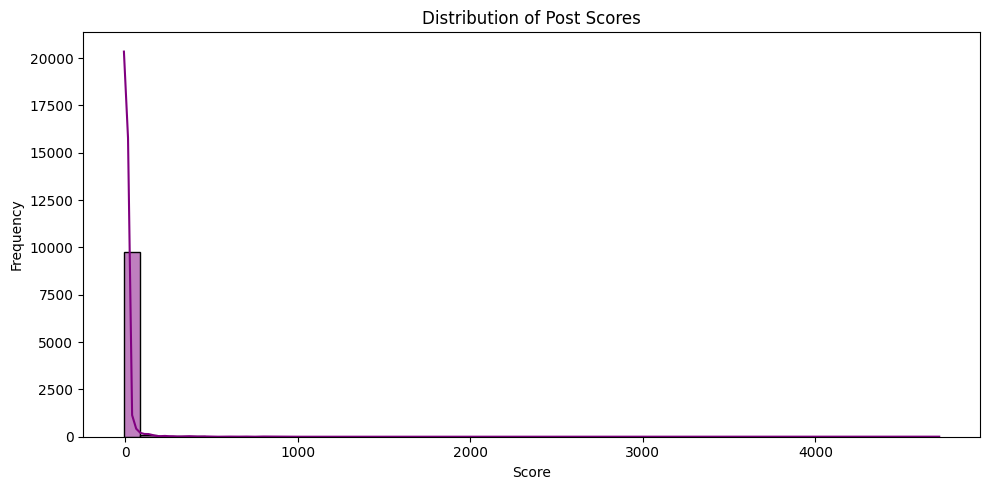

In [5]:
# INITIAL EXPLORATION


print("--- Initial Exploration: Comments Data ---")
print("\nHead of Comments:")
display(comments.head())

print("\nMissing Values:")
display(comments.isnull().sum())

print("\nDuplicate Rows:", comments.duplicated().sum())
print("Unique Users:", comments['user_id'].nunique())
print("Unique Posts:", comments['post_id'].nunique())

print("\n\n--- Initial Exploration: Posts_answers Data ---")
display(posts.head())
display(posts.isnull().sum())
print("Duplicate Rows:", posts.duplicated().sum())

plt.figure(figsize=(10, 5))
sns.histplot(posts['score'].dropna(), bins=50, kde=True, color='purple')
plt.title('Distribution of Post Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



--- Initial Exploration: Users Data ---


,id,display_name,age,location,reputation,up_votes,down_votes
0,15498,Damien_The_Unbeliever,NaN,United Kingdom,229878,3418,452
1,238453,Matt Dunbar,NaN,"Toronto, Canada",890,38,40
2,352765,Spudley,NaN,"England, United Kingdom",163021,7331,300
3,844882,Alex Lockwood,NaN,"San Francisco, CA, USA",82667,2654,910
4,1249581,VisioN,NaN,"Hants, UK",139997,1726,603


id                  0
display_name        2
age             17384
location         6702
reputation          0
up_votes            0
down_votes          0
dtype: int64

Duplicate Rows: 0


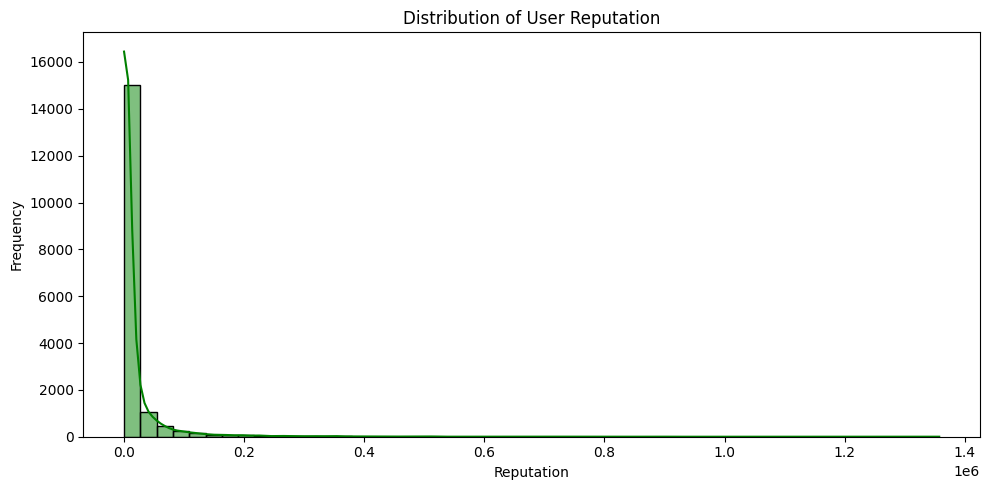


Top 10 User Locations:


location
India                          248
Germany                        230
United States                  174
United Kingdom                 172
London, United Kingdom         159
Berlin, Germany                106
Netherlands                    106
France                          99
Bangalore, Karnataka, India     89
Paris, France                   77
Name: count, dtype: int64

In [6]:
print("\n\n--- Initial Exploration: Users Data ---")
display(users.head())
display(users.isnull().sum())
print("Duplicate Rows:", users.duplicated().sum())

plt.figure(figsize=(10, 5))
sns.histplot(users['reputation'].dropna(), bins=50, kde=True, color='green')
plt.title('Distribution of User Reputation')
plt.xlabel('Reputation')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print("\nTop 10 User Locations:")
display(users['location'].value_counts().head(10))

## Text cleaning 

In [7]:
# TEXT CLEANING UTILITIES


# Regex Patterns
URL_PATTERN = re.compile(r"http\S+|www.\S+")
MEANINGFUL_TEXT_PATTERN = re.compile(r"\w{3,}")
EMOJI_PATTERN = re.compile("[\U0001F600-\U0001F64F"
                           "\U0001F300-\U0001F5FF"
                           "\U0001F680-\U0001F6FF"
                           "\U0001F1E0-\U0001F1FF]+", flags=re.UNICODE)


In [8]:
def has_meaningful_text(text):
    text = URL_PATTERN.sub("", text)
    return bool(MEANINGFUL_TEXT_PATTERN.search(text))

def remove_emojis(text):
    return EMOJI_PATTERN.sub("", text)

def clean_text(text, lower=True, strip=True, remove_urls=True, remove_emojis_flag=True):
    if pd.isna(text):
        return ""
    if lower:
        text = text.lower()
    if remove_urls:
        text = URL_PATTERN.sub("", text)
    if remove_emojis_flag:
        text = remove_emojis(text)
    if strip:
        text = text.strip()
    return text

In [9]:
def clean_comments(df, text_col="text", min_words=3, drop_duplicates=True, remove_emojis_flag=True, lower=True):
    df = df.copy()
    df = df[df[text_col].notna()]
    df = df[df[text_col].str.strip() != ""]
    df[text_col] = df[text_col].apply(lambda x: clean_text(x, lower=lower, remove_emojis_flag=remove_emojis_flag))
    if drop_duplicates:
        df = df.drop_duplicates(subset=[text_col])
    df = df[df[text_col].str.split().str.len() >= min_words]
    df = df[df[text_col].apply(has_meaningful_text)]
    return df.reset_index(drop=True)

# Apply cleaning
comments = clean_comments(comments, min_words=3, remove_emojis_flag=True)


## Basic statistics & visualizations

Number of comments: 20958
Unique users: 17216
Missing values in text: 0


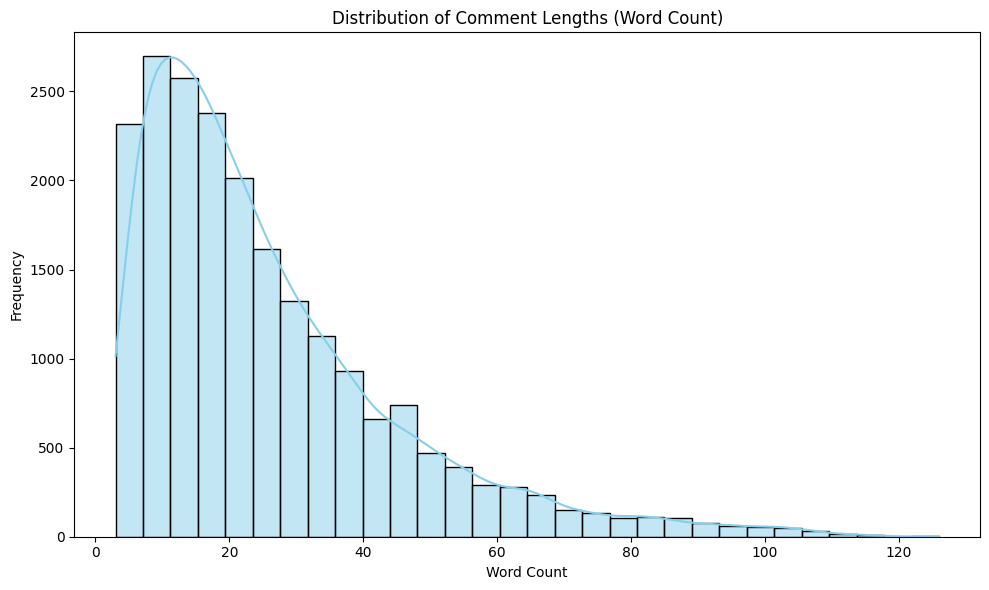

In [10]:
# BASIC STATS & VISUALS


print("Number of comments:", len(comments))
print("Unique users:", comments["user_id"].nunique())
print("Missing values in text:", comments["text"].isna().sum())

# Word Count Distribution
comments["word_count"] = comments["text"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.histplot(comments["word_count"], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Comment Lengths (Word Count)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## Word frequency analysis

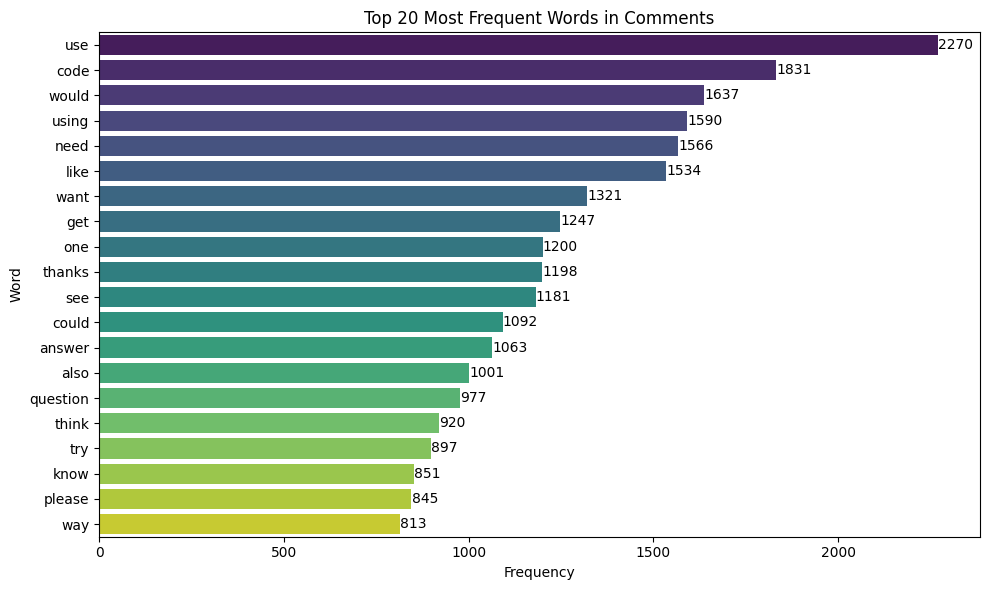

In [11]:
# WORD FREQUENCY ANALYSIS


stop_words = set(stopwords.words("english"))

def tokenize(text):
    return [word.lower() for word in str(text).split() if word.lower() not in stop_words and word.isalpha()]

all_words = sum(comments["text"].apply(tokenize).tolist(), [])
top_words = Counter(all_words).most_common(20)

# Plot Top Words
words, counts = zip(*top_words)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.title("Top 20 Most Frequent Words in Comments")
plt.xlabel("Frequency")
plt.ylabel("Word")

for i, count in enumerate(counts):
    ax.text(count + 0.5, i, str(count), va='center', fontsize=10)
plt.tight_layout()
plt.show()

## Feature extraction (TF-IDF)

In [12]:
# FEATURE EXTRACTION


# Ensure text column is string type
comments['text'] = comments['text'].fillna('').astype(str)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=28000, stop_words='english', ngram_range=(1, 1))
tfidf_matrix = tfidf_vectorizer.fit_transform(comments['text'])

print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"Unique Features Extracted: {len(tfidf_vectorizer.get_feature_names_out())}")

TF-IDF Matrix Shape: (20958, 26679)
Unique Features Extracted: 26679


## Tokenization & Bigram analysis

In [13]:
# TOKENIZATION & BIGRAMS


lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text.lower())
    return [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]

comments['lemmatized_tokens'] = comments['text'].progress_apply(tokenize_and_lemmatize)

# Generate bigrams
bigrams_list = []
for tokens in comments['lemmatized_tokens']:
    bigrams_list.extend(list(nltk.bigrams(tokens)))

bigram_counts = Counter(bigrams_list)
top_bigrams = bigram_counts.most_common(20)

  0%|          | 0/20958 [00:00<?, ?it/s]

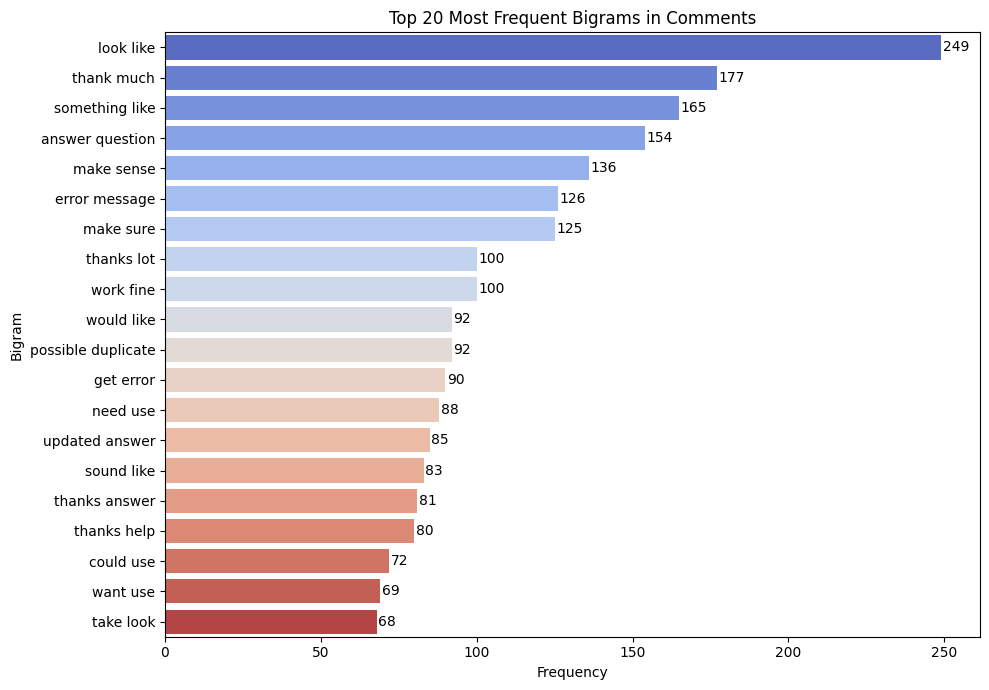

In [14]:
# Plot Top Bigrams
plt.figure(figsize=(10, 7))
bigram_words = [" ".join(bg) for bg, count in top_bigrams]
bigram_counts_val = [count for bg, count in top_bigrams]

ax = sns.barplot(x=bigram_counts_val, y=bigram_words, palette="coolwarm")
plt.title("Top 20 Most Frequent Bigrams in Comments")
plt.xlabel("Frequency")
plt.ylabel("Bigram")

for i, count in enumerate(bigram_counts_val):
    ax.text(count + 0.5, i, str(count), va='center', fontsize=10)
plt.tight_layout()
plt.show()

In [15]:
import time

## Emotion Inference with GoEmotions 🤗

In [16]:
# GoEmotions algorithm from hugging face 


# Define batch inference function
def batch_infer(df, batch_size=16, model_name="SamLowe/roberta-base-go_emotions"):
    classifier = pipeline("text-classification", model=model_name, top_k=None)
    results = []
    texts = df["text"].tolist()

    for i in tqdm(range(0, len(texts), batch_size), desc="Batch Inference"):
        batch = [str(t)[:512] for t in texts[i:i + batch_size]]
        batch_result = classifier(batch)
        results.extend(batch_result)

    return results

# Run the function and time it
print("Running emotion detection with GoEmotions model...")

start_time = time.time()
comments["emotions"] = batch_infer(comments)
comments.to_csv("comments_with_emotions.csv", index=False)
print("---> Saved emotions per comment to comments_with_emotions.csv")

end_time = time.time()

print(f"---> Emotion inference completed in {end_time - start_time:.2f} seconds.")


Running emotion detection with GoEmotions model...


Device set to use cpu


Batch Inference:   0%|          | 0/1310 [00:00<?, ?it/s]

---> Saved emotions per comment to comments_with_emotions.csv
---> Emotion inference completed in 2025.30 seconds.


## Emotion data processing & merging

In [17]:
# Load Comments with Emotions 
comments = pd.read_csv("comments_with_emotions.csv")
comments["emotions"] = comments["emotions"].apply(ast.literal_eval)

print(f" ---> Loaded {len(comments)} comments with parsed emotions.")


 ---> Loaded 20958 comments with parsed emotions.


In [18]:
# Extract Emotion Labels Above a Score Threshold 
def extract_labels(e_list, threshold=0.3):
    """
    Filters emotion predictions above a given score threshold.
    """
    return [e["label"] for e in e_list if e["score"] > threshold]

comments["emotion_labels"] = comments["emotions"].apply(extract_labels)
print(" ---> Extracted emotion labels for each comment.")

 ---> Extracted emotion labels for each comment.


In [19]:
# Explode Multi-Emotion Comments into Rows 
comments_exp = comments.explode("emotion_labels")
comments_exp = comments_exp[comments_exp["emotion_labels"].notna()]
print(f" ---> Exploded to {len(comments_exp)} rows (one row per emotion per comment).")

# Ensure ID Columns Are Numeric for Merging 
comments_exp["user_id"] = pd.to_numeric(comments_exp["user_id"], errors="coerce")
comments_exp["post_id"] = pd.to_numeric(comments_exp["post_id"], errors="coerce")
print(" ---> Converted user_id and post_id to numeric for merging.")

 ---> Exploded to 29088 rows (one row per emotion per comment).
 ---> Converted user_id and post_id to numeric for merging.


In [20]:
# Merge Comments with Users and Posts 
def merge_all(comments_df, users_df, posts_df):
    """
    Merges comment data with user and post metadata.
    """
    merged = comments_df.merge(users_df, left_on="user_id", right_on="id", how="left", suffixes=('', '_user'))
    merged = merged.merge(posts_df, left_on="post_id", right_on="id", how="left", suffixes=('', '_post'))
    return merged

df = merge_all(comments_exp, users, posts)
print(f" ---> Merged with users and posts. Final shape: {df.shape}")


 ---> Merged with users and posts. Final shape: (29088, 20)


In [21]:
# Binning Numeric Columns into Categories 
def bin_column(df, col, bins, labels, new_col):
    """
    Adds a categorical column based on binning of a numeric column.
    """
    df[new_col] = pd.cut(df[col], bins=bins, labels=labels)
    return df

In [22]:
# Reputation Grouping
df = bin_column(
    df, "reputation",
    bins=[-1, 100, 1000, 5000, 20000, float("inf")],
    labels=["Very Low", "Low", "Medium", "High", "Very High"],
    new_col="rep_group"
)

# Post Score Grouping
df = bin_column(
    df, "score_post",
    bins=[-10, 0, 5, 20, 100, float("inf")],
    labels=["Negative", "Low", "Moderate", "High", "Very High"],
    new_col="post_score_group"
)

# Comment Score Grouping
df = bin_column(
    df, "score",
    bins=[-5, 0, 5, 20, 100, float("inf")],
    labels=["Negative", "Low", "Medium", "High", "Very High"],
    new_col="comment_score_group"
)

print(" ---> Created reputation and post score groups.")

 ---> Created reputation and post score groups.


In [23]:
# Display Sample Output 
display(df[[
    "text", "emotion_labels",
    "reputation", "rep_group",
    "score_post", "post_score_group"
]].sample(5))

,text,emotion_labels,reputation,rep_group,score_post,post_score_group
23876,"thank you for the response, it clarifies a lot...",gratitude,11.0,Very Low,2.0,Low
14317,where do you read that? can you give me the url?,curiosity,300.0,Low,NaN,NaN
26788,"excellent, could do it with the solution above?",admiration,696.0,Low,0.0,Negative
12673,there was no completion of this problem. there...,neutral,33.0,Very Low,NaN,NaN
26948,"yes. also, a0=lr.intercept_[0], a1=lr.coef_[0]...",approval,2029.0,Medium,NaN,NaN


## Top comments & confident predictions

In [24]:
# Top-Scoring Comments by Emotion 
top_comments_per_emotion = (
    df[df["emotion_labels"].notna()]
    .groupby("emotion_labels")
    .apply(lambda g: g.sort_values("score", ascending=False).head(1))
)[["text", "score", "display_name", "emotion_labels"]]

print("---> Top-Scoring Comments by Emotion:")
display(top_comments_per_emotion.reset_index(drop=True))

# Most Confident Emotion Predictions 
df["emotion_confidence"] = df["emotions"].apply(lambda x: max([e["score"] for e in x]) if x else 0)
df_top_confident = df.sort_values("emotion_confidence", ascending=False).head(10)

print("---> Most Confident Emotion Predictions:")
display(df_top_confident[["text", "emotion_labels", "emotion_confidence", "score", "display_name"]])


---> Top-Scoring Comments by Emotion:


,text,score,display_name,emotion_labels
0,incredible when one considers the microsoft pr...,3,Dave Lawrence,admiration
1,it's funny how much space a scrollbar takes up...,4,cimmanon,amusement
2,"i hate to get involved again, but ... really, ...",1,r2evans,anger
3,"typical google, taking something that worked j...",30,Synetech,annoyance
4,"as an aside, nm --demangle is pretty useful fo...",19,Carlos Rendon,approval
5,use `concatmap` if you're worried about reques...,8,GFoley83,caring
6,it's been a year and a half? is this still th...,38,Abe,confusion
7,it's been a year and a half? is this still th...,38,Abe,curiosity
8,"thanks, wish i could upvote several times, too...",4,user230910,desire
9,yeah it's removeall. i actually spent the tim...,5,JaredPar,disappointment


---> Most Confident Emotion Predictions:


,text,emotion_labels,emotion_confidence,score,display_name
7517,"thanks a lot, i will give this a try.",gratitude,0.993870,0,anpsmn
4415,thanks for your reply. i will look into how to...,gratitude,0.993667,0,user1349526
27289,"thanks for the feedback, some silly mistakes, ...",gratitude,0.993540,0,Anon122121
3816,"thank you for the link, i had heard of yui ext...",gratitude,0.993457,0,naivists
11158,"okay thanks a lot @chuex, i will try it out to...",gratitude,0.993293,0,Jeevan Dongre
5943,works! thanks a lot. :),gratitude,0.993267,0,manuelJoaquim
13225,"nevermind, i was able to make it work by tweak...",gratitude,0.993111,0,Smiley
5909,"that worked just fine, thanks. i will try the ...",gratitude,0.993093,0,Asker McQuetion
28777,"thank you for the suggestion, will give it a try.",gratitude,0.993035,0,Alessandro Togni
28789,thank you for your help. it works.,gratitude,0.992992,0,Jelena Ajdukovic


## Overall emotion frequency analysis

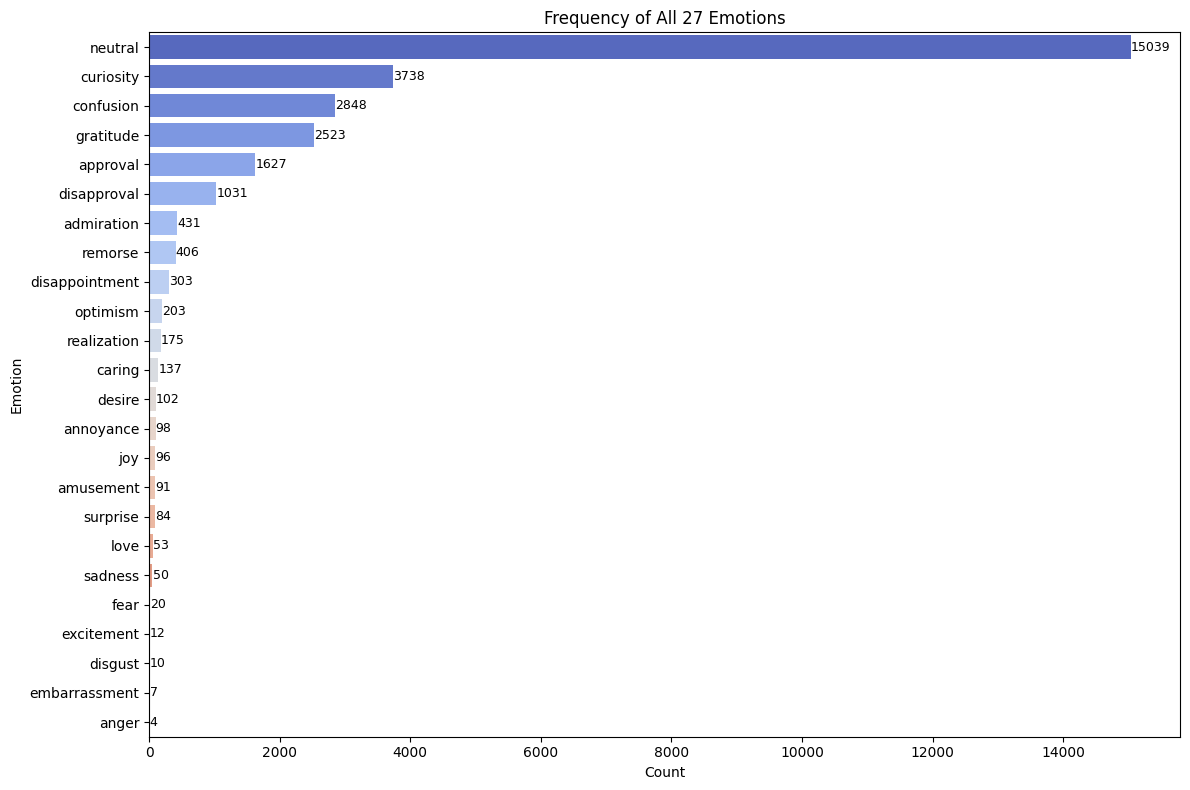

In [25]:
# Bar Plot: Frequency of All 27 Emotions 
from collections import Counter
all_emotions = sum(comments["emotion_labels"].tolist(), [])
emotion_counts = pd.Series(Counter(all_emotions)).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=emotion_counts.values, y=emotion_counts.index, palette="coolwarm")
plt.title("Frequency of All 27 Emotions")
plt.xlabel("Count")
plt.ylabel("Emotion")
for i, (value, label) in enumerate(zip(emotion_counts.values, emotion_counts.index)):
    ax.text(value + 2, i, str(value), va='center', fontsize=9)
plt.tight_layout()
plt.show()

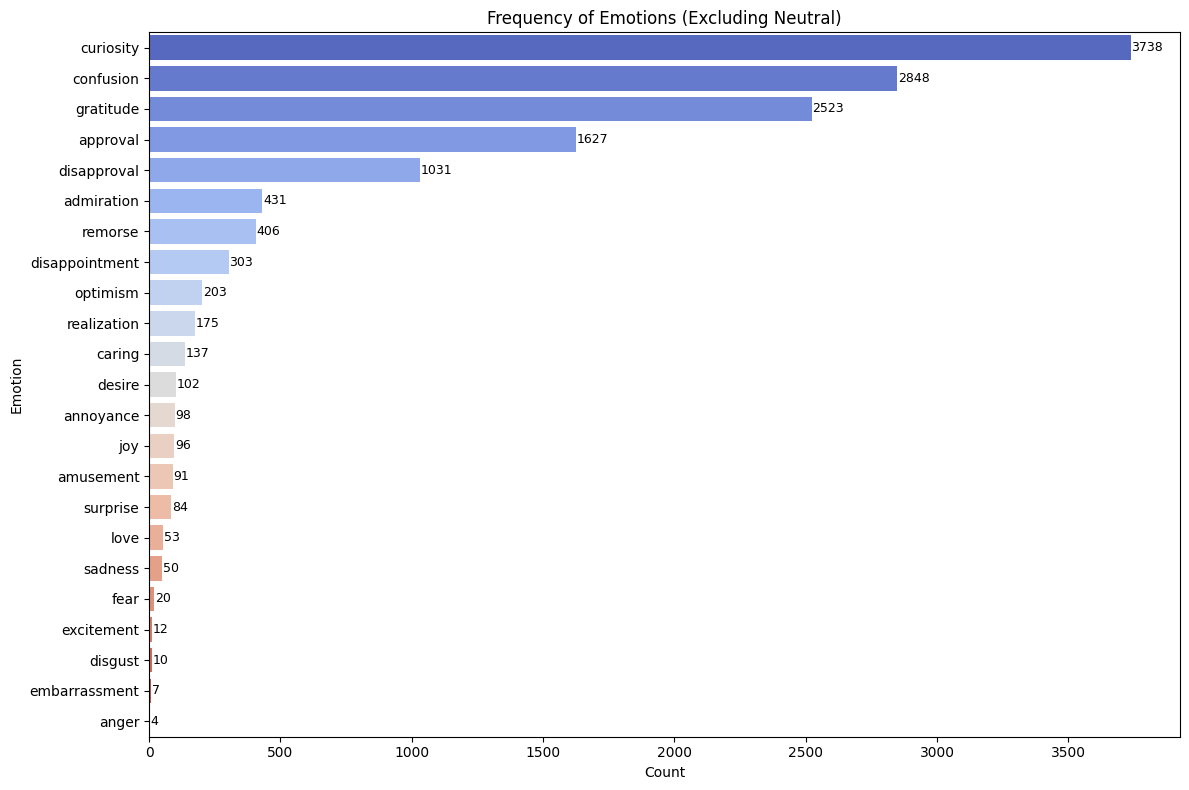

In [26]:
# Bar Plot: Emotions (Excluding Neutral) 
non_neutral_emotions = [e for e in all_emotions if e != "neutral"]
non_neutral_counts = pd.Series(Counter(non_neutral_emotions)).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=non_neutral_counts.values, y=non_neutral_counts.index, palette="coolwarm")
plt.title("Frequency of Emotions (Excluding Neutral)")
plt.xlabel("Count")
plt.ylabel("Emotion")
for i, (value, label) in enumerate(zip(non_neutral_counts.values, non_neutral_counts.index)):
    ax.text(value + 2, i, str(value), va='center', fontsize=9)
plt.tight_layout()
plt.show()

## Emotion distribution by Post/Comment popularity

In [27]:
# Re-bin Comment Scores for Plotting 
df["comment_score_group"] = pd.cut(
    df["score"],
    bins=[-5, 0, 5, 20, 100, float("inf")],
    labels=["Negative", "Low", "Medium", "High", "Very High"]
)

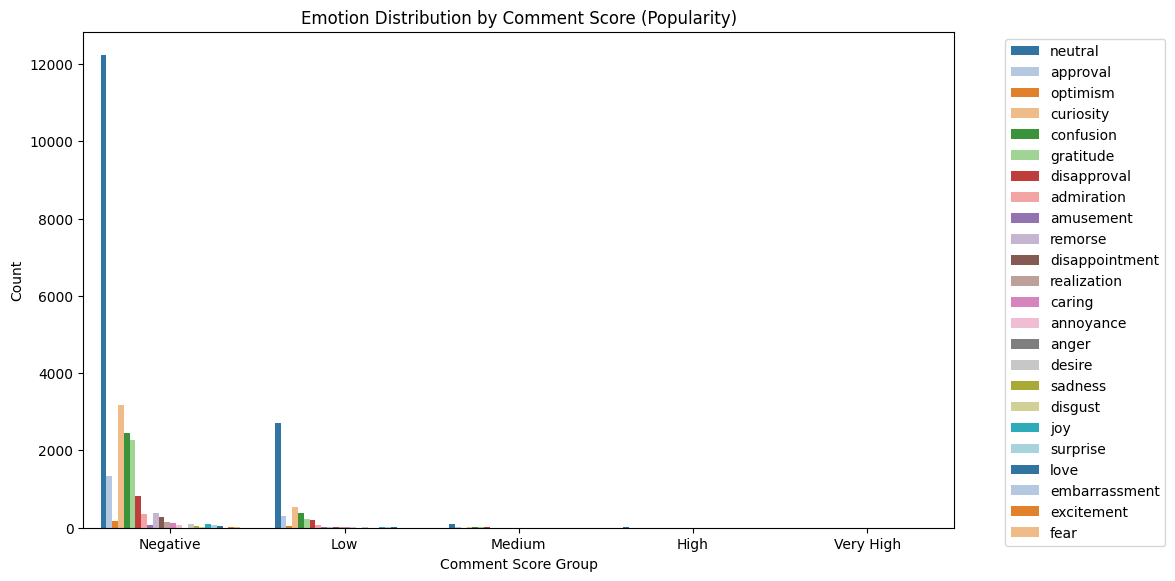

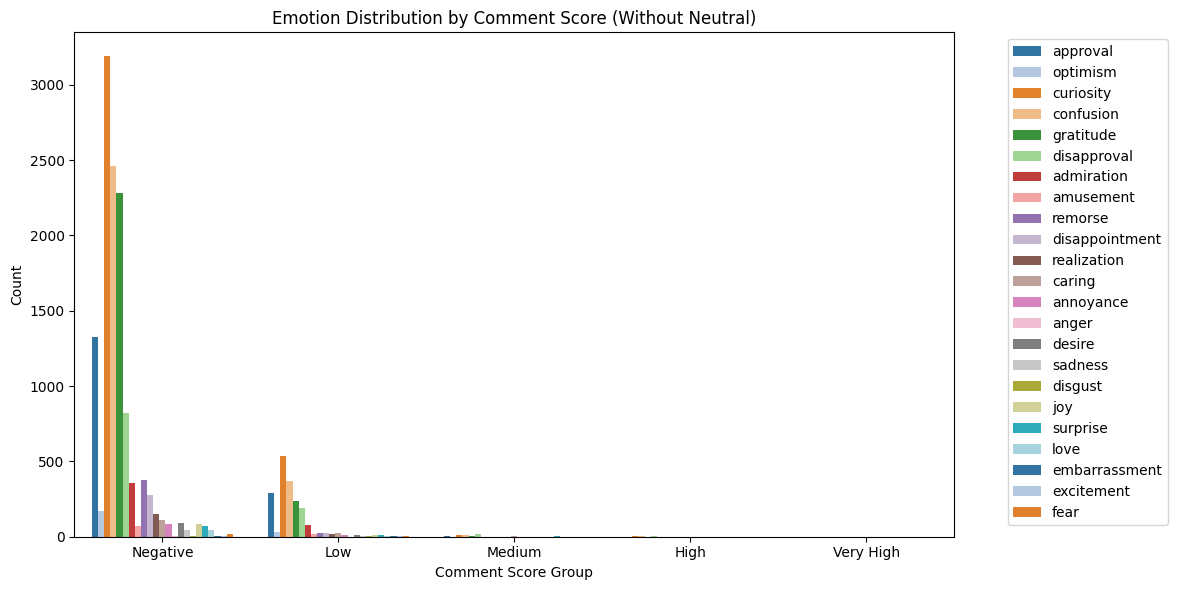

In [28]:
# Plot: Emotion Distribution by Comment Score 
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="comment_score_group", hue="emotion_labels", palette="tab20")
plt.title("Emotion Distribution by Comment Score (Popularity)")
plt.xlabel("Comment Score Group")
plt.ylabel("Count")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.show()

df_no_neutral = df[df["emotion_labels"] != "neutral"]

plt.figure(figsize=(12, 6))
sns.countplot(data=df_no_neutral, x="comment_score_group", hue="emotion_labels", palette="tab20")
plt.title("Emotion Distribution by Comment Score (Without Neutral)")
plt.xlabel("Comment Score Group")
plt.ylabel("Count")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.show()


In [29]:
# Re-bin Post Scores for Plotting 
df["post_score_group"] = pd.cut(
    df["score_post"],
    bins=[-10, 0, 5, 20, 100, float("inf")],
    labels=["Negative", "Low", "Medium", "High", "Very High"]
)

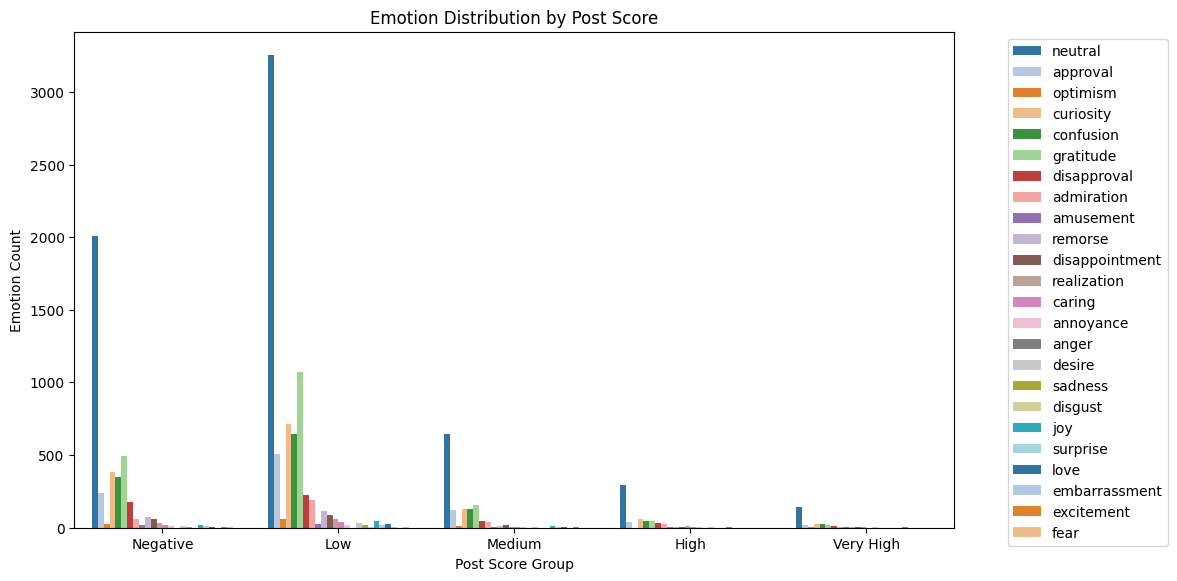

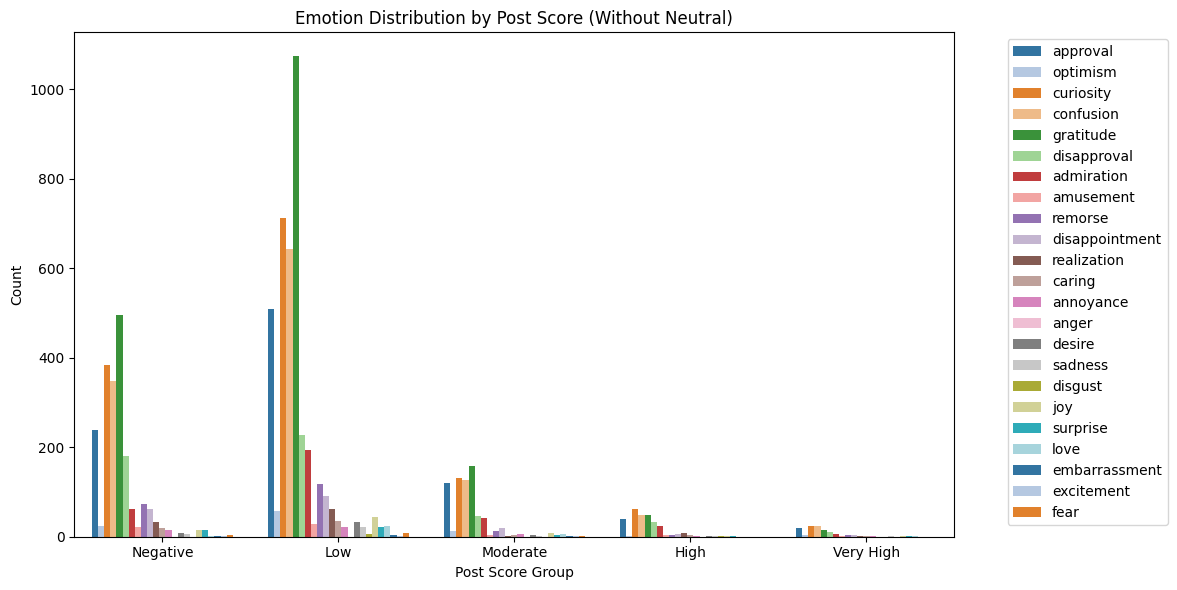

In [30]:
# Plot: Emotion Distribution by Post Score 
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="post_score_group", hue="emotion_labels", palette="tab20")
plt.title("Emotion Distribution by Post Score")
plt.xlabel("Post Score Group")
plt.ylabel("Emotion Count")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.show()


# Exclude Neutral

plt.figure(figsize=(12, 6))
sns.countplot(data=df_no_neutral, x="post_score_group", hue="emotion_labels", palette="tab20")
plt.title("Emotion Distribution by Post Score (Without Neutral)")
plt.xlabel("Post Score Group")
plt.ylabel("Count")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.show()

## Geographical emotion analysis

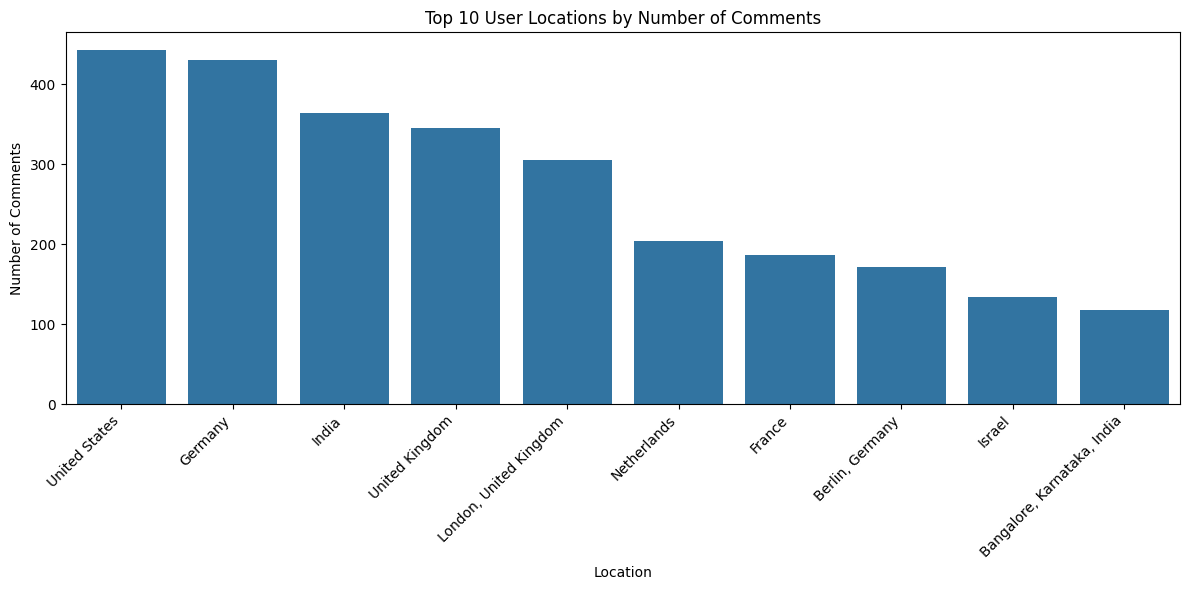

In [31]:
# Clean and Analyze User Locations 
df_clean = df.copy()
df_clean["location"] = df_clean["location"].replace(["United States", "USA"], "United States")

top_locations_clean = df_clean["location"].value_counts().nlargest(10).index
df_top_loc_clean = df_clean[df_clean["location"].isin(top_locations_clean)]

plt.figure(figsize=(12, 6))
sns.countplot(data=df_top_loc_clean, x="location", order=top_locations_clean)
plt.title("Top 10 User Locations by Number of Comments")
plt.xlabel("Location")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

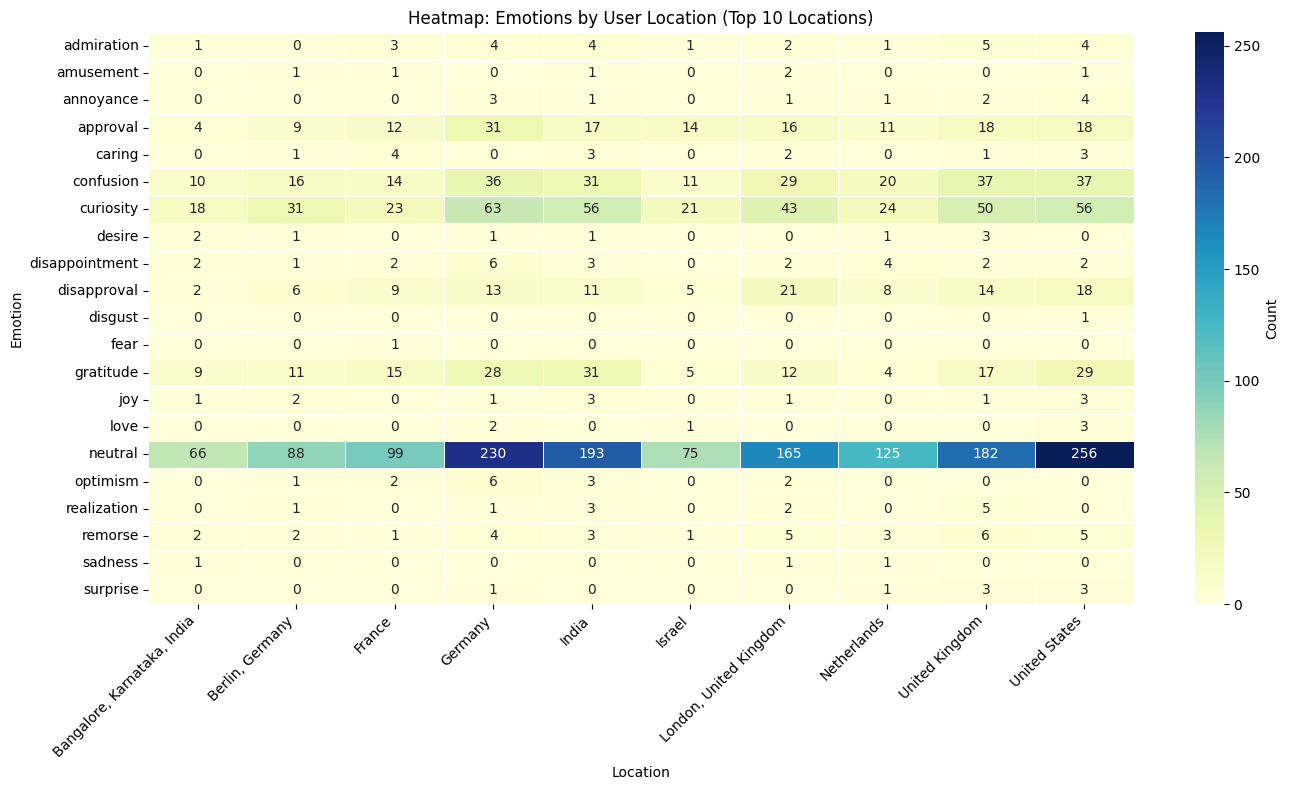

In [32]:
# Heatmap: Emotions by Location (Top 10) 
df["location"] = df["location"].replace({"USA": "United States", "U.S.": "United States"})
top_locations = df["location"].value_counts().nlargest(10).index
df_top_loc = df[df["location"].isin(top_locations)]

heatmap_data = df_top_loc.groupby(["emotion_labels", "location"]).size().unstack(fill_value=0)

plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "Count"}
)
plt.title("Heatmap: Emotions by User Location (Top 10 Locations)")
plt.xlabel("Location")
plt.ylabel("Emotion")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


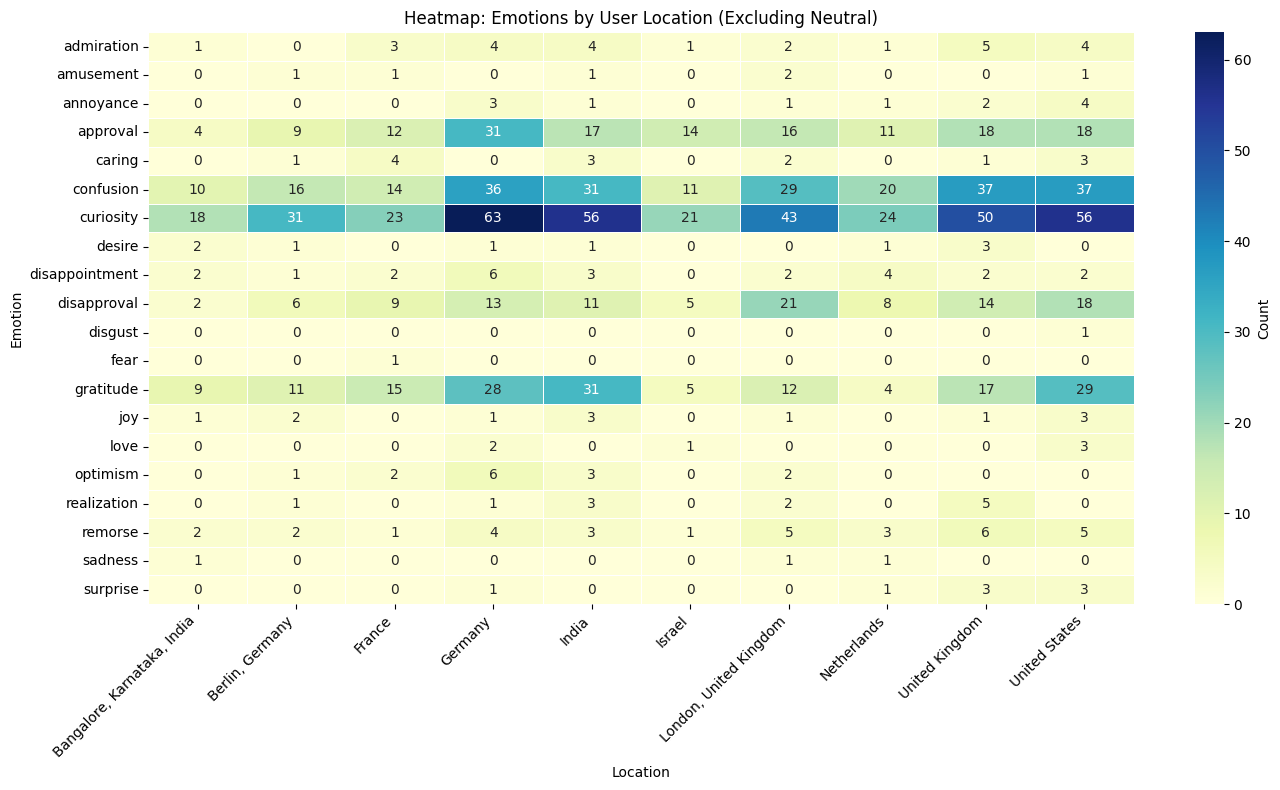

In [33]:
# Heatmap: Emotions by Location (Excluding Neutral) 
heatmap_no_neutral = df_top_loc_clean[df_top_loc_clean["emotion_labels"] != "neutral"] \
    .groupby(["emotion_labels", "location"]).size().unstack(fill_value=0)

plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_no_neutral,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "Count"}
)
plt.title("Heatmap: Emotions by User Location (Excluding Neutral)")
plt.xlabel("Location")
plt.ylabel("Emotion")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Emotions based on Upvotes-Downvotes analysis

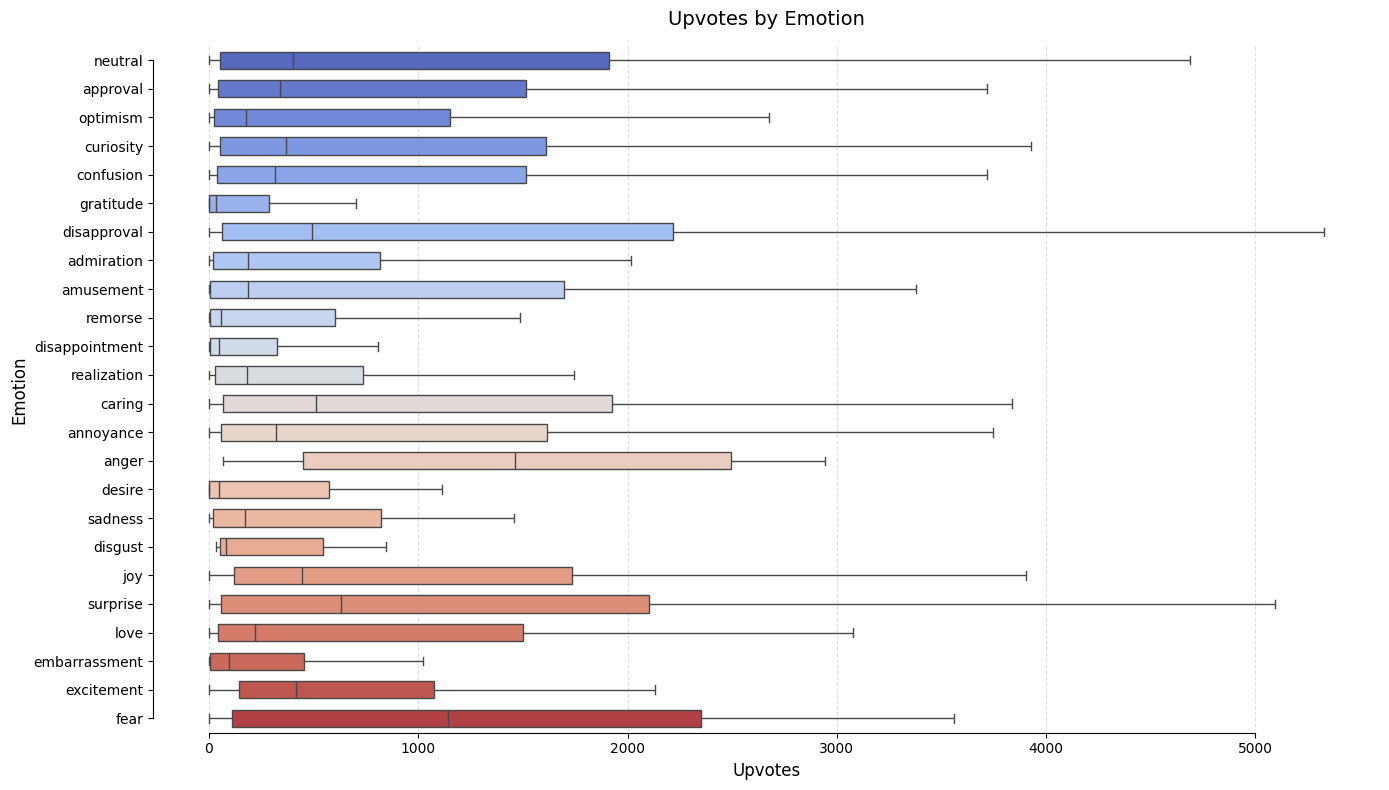

In [34]:
# Box Plot: Upvotes by Emotion 
plt.figure(figsize=(14, 8))
sns.boxplot(
    data=df,
    y="emotion_labels",
    x="up_votes",
    palette="coolwarm",
    showfliers=False,
    width=0.6
)
plt.title("Upvotes by Emotion", fontsize=14, pad=15)
plt.xlabel("Upvotes", fontsize=12)
plt.ylabel("Emotion", fontsize=12)
plt.ticklabel_format(style="plain", axis="x")
sns.despine(trim=True)
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

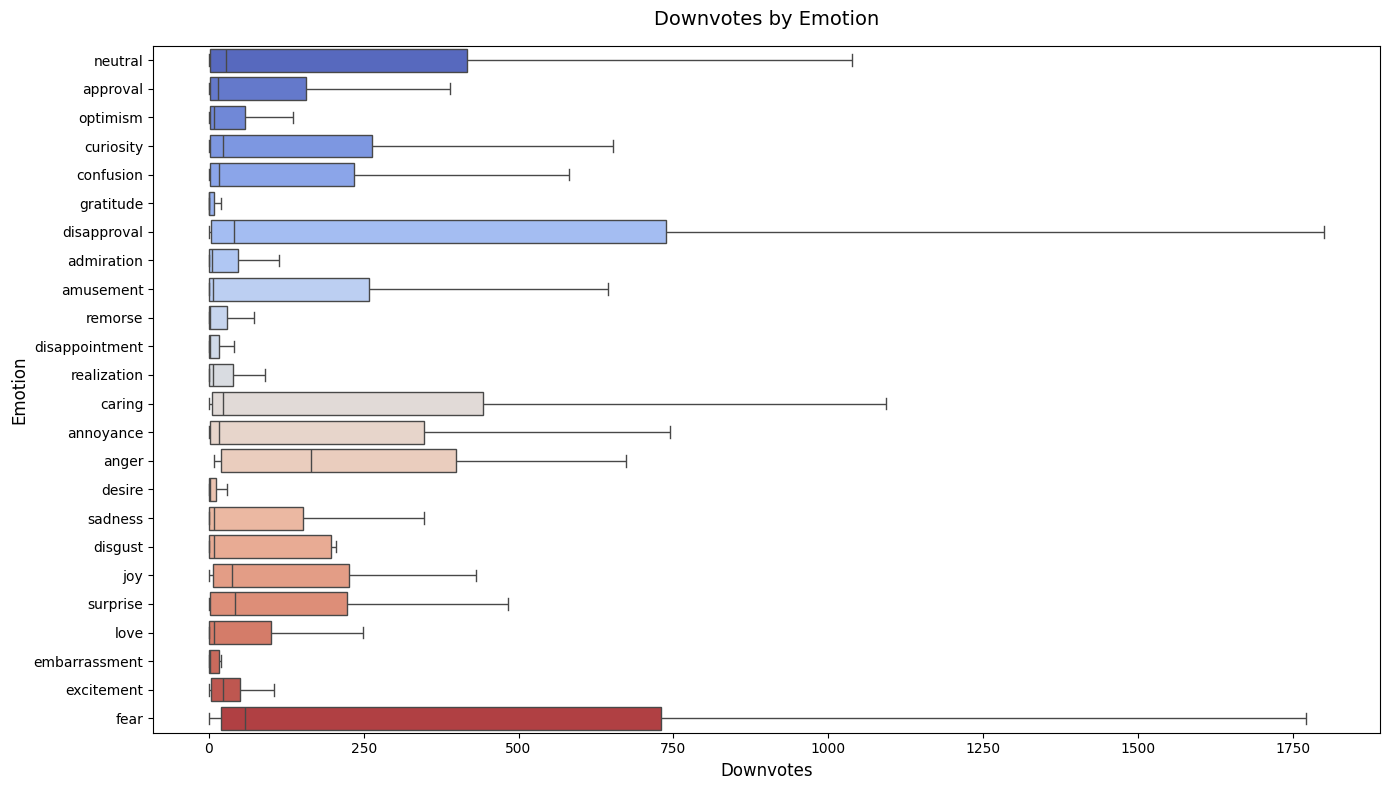

In [35]:
# Box Plot: Downvotes by Emotion 
plt.figure(figsize=(14, 8))
sns.boxplot(
    data=df,
    y="emotion_labels",
    x="down_votes",
    palette="coolwarm",
    showfliers=False
)
plt.title("Downvotes by Emotion", fontsize=14, pad=15)
plt.xlabel("Downvotes", fontsize=12)
plt.ylabel("Emotion", fontsize=12)
plt.tight_layout()
plt.show()


---

# Conclusion and Future Work

## Key Findings

This comprehensive analysis has illuminated several key aspects of the emotional landscape and dynamics within the stack-overflow community:

* **Dominance of Neutrality and Positive Emotions:** Our analysis, powered by the GoEmotions model, revealed that a significant portion of comments are classified as "neutral." Among the non-neutral emotions, positive emotions such as **`curiosity`**, **`confusion`**, and **`graditute`** are frequently expressed. This suggests a generally constructive and inquisitive environment.
* **Correlation with Popularity Metrics:** Comments and posts with higher scores (indicating popularity/upvotes) tend to be associated with positive emotions (e.g., `gratitude`, `admiration`), while negative or less constructive emotions (e.g., `disappointment`, `annoyance`) show a tendency towards lower scores or more downvotes. This reinforces the idea that positive contributions are generally well-received.
* **Geographical Nuances:** While overall emotion distributions are consistent, the heatmap analysis revealed subtle regional differences in emotion prevalence. Certain locations might show a slightly higher propensity for specific emotions, suggesting cultural or contextual influences on online expression.
* **Common Themes:** The word frequency and bigram analysis highlighted recurring topics and phrases. For instance, common technical terms or community-specific jargon often appear alongside relevant emotions.

## Limitations

While this study provides valuable insights, it's important to acknowledge its limitations:

* **Model Dependency:** The accuracy of emotion classification heavily relies on the GoEmotions model. While powerful, no model is perfect, and it may misinterpret nuanced language, sarcasm, or highly domain-specific jargon.
* **Data Bias:** The analysis is inherently limited by the characteristics of the source data. Biases present in the original comments, user demographics, or platform dynamics could influence the observed emotional patterns.
* **Absence of Temporal Analysis:** Without timestamp information, we could not analyze how emotions evolve over time, identify trends, or react to specific events.

## Future Work

To further enhance this analysis and address the identified limitations, consider the following avenues for future research:

* **Temporal Emotion Trends:** Incorporate timestamp data to analyze emotion trends over days, weeks, or months, and investigate how emotions correlate with significant platform events or external factors.
* **Aspect-Based Emotion Analysis (ABSA):** Go beyond comment-level emotions to identify emotions directed towards specific entities or aspects mentioned within the text (e.g., "The *feature* is frustrating," "The *community support* is amazing"). This provides a more granular understanding.
* **Sarcasm and Irony Detection:** Implement or fine-tune models specifically designed to detect sarcasm and irony, which are challenging for standard emotion classifiers but crucial for accurate interpretation of online text.
* **User Emotion Profiles:** Develop user-specific emotion profiles to understand if certain users consistently express particular emotions, providing insights into user behavior and engagement styles.
* **Comparative Analysis:** Compare emotion distributions across different types of posts (e.g., questions vs. answers) or different communities/forums to identify platform-specific emotional characteristics.

This analysis serves as a robust foundation for understanding the emotional dynamics within this online community, paving the way for more targeted improvements in content engagement and user experience.